<div style="text-align: left">
 <img src="./graph/LogoParisSaclay.png" width="850px">
</div>

#  <a style="color:#920037"> DataCamp Project - Tennis Match Prediction </a>

### Authors : Bilal MELLOUKI - Aimane EL MAIMOUNI

#### M2 Data Science - Université Paris Saclay  
 
**Professors :** Alexandre GRAMFORT & Balazs KEGL

# <a style="color:#920037"> 1. TASK EXPLANATION </a>

For this challenge, we will try to predict a tennis match result based on data collected from the Association of Tennis Professionals (ATP), The data gathers outcomes ATP tennis games over several years. We aim to create a predictive model based on this data set.

For educatif perposes, we will present to you the acctuel players ranking of ATP :

<div style="text-align: left">
 <img src="./graph/ATP.png" width="350px">
</div>

# <a style="color:#920037"> 1. DATA exploration </a>
## <a style="color:#920037"> 1.1 Data downloding </a>

In [35]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
from sklearn.utils import shuffle
import zipfile
from glob import glob
import warnings 
from keras.models import Sequential
from keras.layers import Dense
from tqdm import tnrange
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc 
from sklearn.linear_model import LogisticRegression
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")
logging.getLogger().setLevel('INFO')

In [36]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()
    

BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

In [37]:
data = df_atp.copy()

## <a style="color:#920037"> 1.2 Some informations from the data  </a>

#### Who are the three ATP players with the most wins ?

In [4]:
players = df_atp.Winner.value_counts()[:3].index
wins = result = df_atp.Winner.value_counts()[:3].values
print("the three ATP players with the most wins are:\n%s with %d wins\n%s with %d wins\n%s with %d wins "
      %(players[0],wins[0],players[1],wins[1],players[2],wins[2]))

the three ATP players with the most wins are:
Federer R. with 1121 wins
Nadal R. with 891 wins
Djokovic N. with 802 wins 


#### How many sets did the player “Federer R.” win in total ?

The idea is to add the sets won by Federer when he lost the match and the ones he won when he lost the match

During the count of the number of sets that Federer won when he lost the match, we had a problem that in the instance 18827 Federer lost but he won '`1' set, so we will change this string value into a float as it should be.

In [5]:
#the 18827 instance :
df_atp.iloc[18827]

ATP                            31
AvgL                          NaN
AvgW                          NaN
B&WL                          NaN
B&WW                          NaN
B365L                        2.25
B365W                        1.61
Best of                         5
CBL                          2.15
CBW                           1.7
Comment                 Completed
Court                     Outdoor
Date          2006-06-11 00:00:00
EXL                          2.15
EXW                          1.65
GBL                           NaN
GBW                           NaN
IWL                           NaN
IWW                           NaN
L1                              6
L2                              1
L3                              4
L4                              6
L5                            NaN
LBL                           NaN
LBW                           NaN
LPts                         7010
LRank                           1
Location                    Paris
Loser         

In [6]:
#we fix this isuu now :
df_atp.Lsets[18827] = int(1)
#we check this instance now:
df_atp.iloc[18827]

ATP                            31
AvgL                          NaN
AvgW                          NaN
B&WL                          NaN
B&WW                          NaN
B365L                        2.25
B365W                        1.61
Best of                         5
CBL                          2.15
CBW                           1.7
Comment                 Completed
Court                     Outdoor
Date          2006-06-11 00:00:00
EXL                          2.15
EXW                          1.65
GBL                           NaN
GBW                           NaN
IWL                           NaN
IWW                           NaN
L1                              6
L2                              1
L3                              4
L4                              6
L5                            NaN
LBL                           NaN
LBW                           NaN
LPts                         7010
LRank                           1
Location                    Paris
Loser         

In [7]:
#now we add the sets won by 'Federer R.' when he lost the match and when he won it
result = df_atp.Wsets[df_atp.Winner=='Federer R.'].sum() + df_atp.Lsets[df_atp.Loser=='Federer R.'].sum()
print("The number of sets did the player Federer R. win in total is : %d"%(int(result)))

The number of sets did the player Federer R. win in total is : 2696


#### How many sets did the player “Federer R.” win during the years 2016 and 2017 ? 

In [8]:
df_atp_date= df_atp[(df_atp.Date>='2016') & (df_atp.Date<'2018')]
result = df_atp_date.Wsets[df_atp_date.Winner=='Federer R.'].sum() + df_atp_date.Lsets[df_atp_date.Loser=='Federer R.'].sum()
print("The number of sets did the player Federer R. win during the years 2016 and 2017  is : %d"%(int(result)))

The number of sets did the player Federer R. win during the years 2016 and 2017  is : 182


#### For each match, what is the percentage of victories of the winner in the past ?

The data is ranked by time so to calculate the number of wins for a player X before match i, we should compute his wins from the previous i instances

If the player is playing his first match, then the fraction will be replaced by "first match"

In [9]:
percentage_of_victories = []
n = len(df_atp)#the number of instances
for i in tnrange(n):
    winner = df_atp.iloc[i].Winner
    previous_knowledge = df_atp.iloc[:i]
    match_played = len(previous_knowledge[(previous_knowledge.Winner == winner) | (previous_knowledge.Loser == winner)])
    previous_wins = len(previous_knowledge[(previous_knowledge.Winner == winner)])
    if(match_played ==0):
        percentage_of_victories.append("first match")
        pass
    else:
        percentage_of_victories.append(previous_wins/match_played)
percentage_of_victories = pd.Series(percentage_of_victories)
percentage_of_victories

0        first match
1        first match
2        first match
3        first match
4        first match
5        first match
6        first match
7        first match
8        first match
9        first match
10       first match
11       first match
12       first match
13       first match
14       first match
15       first match
16                 1
17                 1
18                 1
19                 1
20                 1
21                 1
22                 1
23                 1
24                 1
25                 1
26                 1
27                 1
28                 1
29                 1
            ...     
52268       0.652941
52269        0.56338
52270       0.829854
52271       0.666667
52272       0.570397
52273       0.633431
52274       0.829866
52275       0.669866
52276       0.566434
52277       0.634503
52278       0.830031
52279       0.829993
52280       0.569444
52281       0.830208
52282       0.572414
52283       0.589354
52284       0

## <a style="color:#920037"> 1.2 Some Graphs  </a>

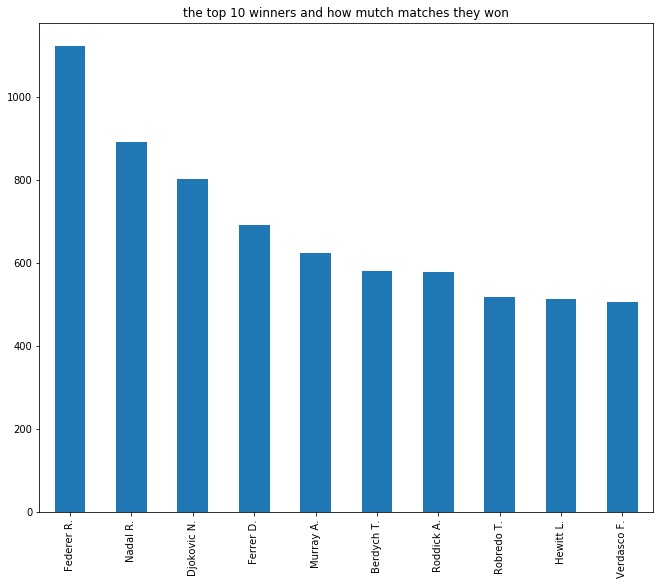

In [10]:
#the top 10 winners and how mutch matches they won
winners = dict(df_atp.Winner.value_counts()[:10])
winners = pd.DataFrame.from_dict(winners, orient='index')
winners.plot(kind='bar',legend=False,title = "the top 10 winners and how mutch matches they won",figsize=(11,9))
plt.show()

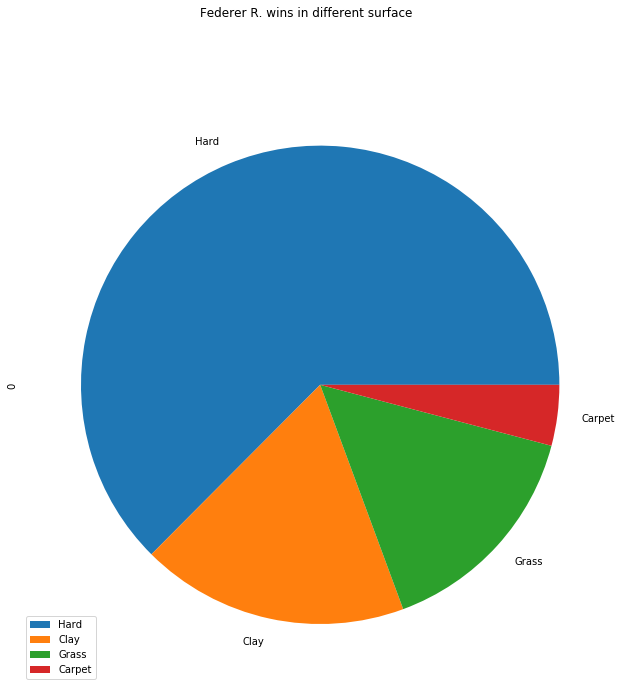

In [11]:
#Federer R. wins in different surface
Surface = dict(df_atp[df_atp.Winner=="Federer R."].Surface.value_counts()[:10])
Surface = pd.DataFrame.from_dict(Surface, orient='index')
Surface.plot(kind='pie',subplots=True,figsize =(15,11),title ="Federer R. wins in different surface")

plt.show()

We can see that Federer R. had his most wins up a Hard surface

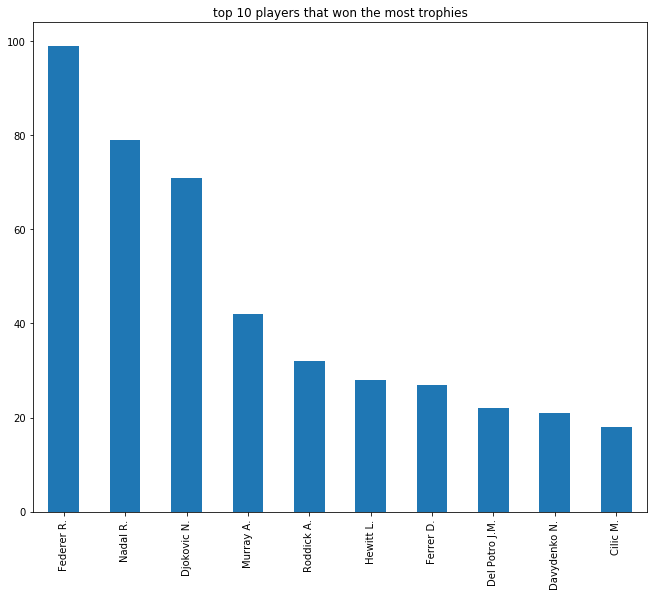

In [12]:
#players that won the most trophies
winners = dict(df_atp[df_atp.Round=="The Final"].Winner.value_counts()[:10])
winners = pd.DataFrame.from_dict(winners, orient='index')
winners.plot(kind='bar',legend=False,title = "top 10 players that won the most trophies",figsize=(11,9))
plt.show()

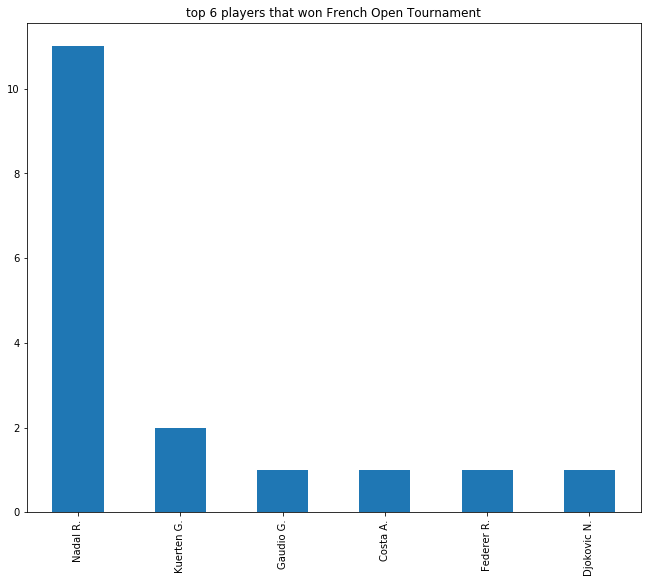

In [13]:
#most 6 players that won French Open Tournament
winners = dict(df_atp[(df_atp.Round=="The Final") & (df_atp.Tournament=="French Open")].Winner.value_counts()[:6])
winners = pd.DataFrame.from_dict(winners, orient='index')
winners.plot(kind='bar',legend=False,title = "top 6 players that won French Open Tournament",figsize=(11,9))
plt.show()

# <a style="color:#920037"> 2. DATA PREPROCESSING </a>
## <a style="color:#920037"> 2.1 visualisation and columns dropping</a>

In [38]:
#how the data looks like
df_atp.sample(7)

ATP  AvgL  AvgW  B&WL  B&WW  B365L  B365W  Best of   CBL   CBW  ...  \
18096   19   NaN   NaN   NaN   NaN  1.530  2.370        3  1.50  2.60  ...   
40865   41  2.08  1.72   NaN   NaN  2.100  1.660        3   NaN   NaN  ...   
29411   20   NaN   NaN   NaN   NaN  2.620  1.500        3   NaN   NaN  ...   
8315    53   NaN   NaN   NaN   NaN  2.625  1.444        3  2.55  1.48  ...   
17660    6   NaN   NaN   NaN   NaN  2.100  1.660        5  2.20  1.67  ...   
42162   11  1.46  2.62   NaN   NaN  1.400  2.750        3   NaN   NaN  ...   
6077     5   NaN   NaN   NaN   NaN    NaN    NaN        3  4.75  1.14  ...   

        UBW   W1 W2   W3   W4   W5    WPts  WRank              Winner  Wsets  
18096  2.45  6.0  6  NaN  NaN  NaN   576.0     70        Bracciali D.    2.0  
40865   NaN  7.0  6  NaN  NaN  NaN   604.0     92  Estrella Burgos V.    2.0  
29411   NaN  7.0  6  NaN  NaN  NaN  3960.0      8          Roddick A.    2.0  
8315    NaN  4.0  6    4  NaN  NaN     NaN     57         Meligeni F.    1.0  
17660  1.70  6.0  3    7  4.0  6.0  1645.0     13        Johansson T.    3.0  
42162   NaN  6.0  6  NaN  NaN  NaN   734.0     69       Stakhovsky S.    2.0  
6077    NaN  6.0  6    7  NaN  NaN     NaN     15          Roddick A.    2.0  

[7 rows x 54 columns]

In [39]:
#missing values ratio for each feature 
df_atp.isna().sum()/len(df_atp)

ATP           0.000000
AvgL          0.565089
AvgW          0.565089
B&WL          0.979024
B&WW          0.979024
B365L         0.165054
B365W         0.165494
Best of       0.000000
CBL           0.665264
CBW           0.665264
Comment       0.000000
Court         0.000000
Date          0.000000
EXL           0.246319
EXW           0.246415
GBL           0.903342
GBW           0.903342
IWL           0.744579
IWW           0.744579
L1            0.004991
L2            0.014742
L3            0.537879
L4            0.909538
L5            0.965754
LBL           0.461891
LBW           0.462102
LPts          0.310968
LRank         0.001491
Location      0.000000
Loser         0.000000
Lsets         0.004302
MaxL          0.565089
MaxW          0.565089
PSL           0.286034
PSW           0.286034
Round         0.000000
SBL           0.896287
SBW           0.896287
SJL           0.702111
SJW           0.702245
Series        0.000000
Surface       0.000000
Tournament    0.000000
UBL        

In [40]:
#Comment feature
df_atp.Comment.value_counts()*100 / df_atp.shape[0]

Completed       96.290489
Retired          3.212360
Walkover         0.493327
Disqualified     0.001912
Sched            0.001912
Name: Comment, dtype: float64

##### we can safely keep instances that  Comment == Completed because it represents 96 of the comment values

In [41]:
#drop instances when Comment is not Completed
not_in  = df_atp[df_atp.Comment!="Completed"].index.values
df_atp.drop(not_in,axis=0,inplace=True)

In [42]:
#now we can drop the Comment column because it's a constant
df_atp = df_atp.drop(columns="Comment")

##### we see that a lot of columns have a huge missing values ratio, so we will delete alot of them, we will delete :
##### 'ATP', 'AvgL', 'AvgW', 'B&WL', 'B&WW','Best of','CBL', 'CBW', 'EXL', 'EXW', 'GBL', 'GBW', 'IWL', 'IWW','L1', 'L2', 'L3', 'L4', 'L5', 'LBL', 'LBW','W1','W2','W3','W4','W5','MaxL', 'MaxW', 'PSL', 'PSW', 'SBL', 'SBW', 'SJL','SJW', 'Series', 'UBL',"Round",'UBW','Wsets','Lsets'

##### As we are predecting the winner, we don't have a great interrest in the winner or loser sets, so we will drop them, we can use them to decide the performance of the winner and the loser, but we will use another formula for performance.

##### The Round and Series don't play a relevant role in detecting the winner, for this reason, we will drop them.

##### Similar arguments could justify why we dropped other columns.

In [43]:
df_atp.drop(columns=['ATP', 'AvgL', 'AvgW', 'B&WL', 'B&WW','Best of',
       'CBL', 'CBW', 'GBL', 'GBW', 'IWL', 'IWW',
       'L1', 'L2', 'L3', 'L4', 'L5', 'LBL', 'LBW','W1','W2','W3','W4','W5',
       'MaxL', 'MaxW', 'PSL', 'PSW', 'SBL', 'SBW', 'SJL',
       'SJW', 'Series', 'UBL',"Round",'UBW','Wsets','Lsets'],inplace=True)

In [44]:
df_atp.isna().sum()/len(df_atp)

B365L         0.166051
B365W         0.166448
Court         0.000000
Date          0.000000
EXL           0.247051
EXW           0.247150
LPts          0.312383
LRank         0.001489
Location      0.000000
Loser         0.000000
Surface       0.000000
Tournament    0.000000
WPts          0.311271
WRank         0.000298
Winner        0.000000
dtype: float64

In [45]:
#drop all the remaining missing values 
df_atp.dropna(inplace=True)

## <a style="color:#920037"> 2.2 Columns transformation :</a>

#### As the rank of the two players should have the same importance,to force your algorithm to give them the same weight, we will use the formula Rank = Rank1-Rank2, also we are just interested  by the difference of ranks not the rank itself . The same logic is applied to Pts and B365 and others .

In [46]:
#replace instances rank when Lrank or Wrank are nor recorded by 0
df_atp.LRank = df_atp.LRank.replace('NR',0)
df_atp.WRank = df_atp.WRank.replace('NR',0)

#add a new column rank = rank_Loser - rank_Winner
df_atp.Rank = df_atp.LRank-df_atp.WRank
df_atp.insert(15,"Rank",df_atp.Rank)

#drop the two WRank and LRank
df_atp.drop(columns=["LRank","WRank"],axis=1,inplace=True)

In [47]:
#reindex the data 
df_atp.reset_index(inplace=True)
df_atp.drop(columns=["index"],inplace=True)
#during the preprossesing we ramrked taht EXW have a string value so we will drop this instance
df_atp.drop(20273, axis=0,inplace=True)

In [48]:
#doing the same for other features
df_atp.Pts = df_atp.LPts-df_atp.WPts
df_atp.insert(14,"Pts",df_atp.Pts)
df_atp.drop(columns=["LPts","WPts"],axis=1,inplace=True)

df_atp.B365 = df_atp.B365L-df_atp.B365W
df_atp.insert(1,"B365",df_atp.B365)

df_atp.EX = df_atp.EXL-df_atp.EXW
df_atp.insert(1,"EX",df_atp.EX)
#reindex the data:
df_atp.reset_index(inplace=True)
df_atp.drop(columns=["index"],inplace=True)
df_atp.drop(columns=["B365W","B365L","EXL","EXW"],axis=1,inplace=True)

In [49]:
#our new data
df_atp.head()

EX  B365    Court       Date Location          Loser Surface  \
0  5.65  4.90  Outdoor 2005-07-04   Bastad      Tabara M.    Clay   
1 -0.05 -0.44  Outdoor 2005-07-04   Bastad  Ryderstedt M.    Clay   
2  3.05  2.81  Outdoor 2005-07-05   Bastad     Haehnel J.    Clay   
3  7.45  5.93  Outdoor 2005-07-05   Bastad      Dlouhy L.    Clay   
4  2.65  2.81  Outdoor 2005-07-05   Bastad         Kim K.    Clay   

     Tournament          Winner   Rank     Pts  
0  Swedish Open      Robredo T.   92.0 -1044.0  
1  Swedish Open  Vinciguerra A. -785.0   317.0  
2  Swedish Open      Youzhny M.   82.0  -809.0  
3  Swedish Open    Ferrero J.C.  105.0  -835.0  
4  Swedish Open      Berdych T.   29.0  -270.0

### we will now add two features, performance and experience , the performance of player is the ratio of matches he won over all the matches be played,  and the experience simply is how matches he played .

In [50]:
winner_performance = []
Wexperience = []
n = len(df_atp)#the number of instances
for i in tnrange(n):
    winner = df_atp.iloc[i].Winner
    previous_knowledge = df_atp.iloc[:i]
    match_played = len(previous_knowledge[(previous_knowledge.Winner == winner) | (previous_knowledge.Loser == winner)])
    previous_wins = len(previous_knowledge[(previous_knowledge.Winner == winner)])
    Wexperience.append(match_played)
    if(match_played ==0):
        winner_performance.append(-1)#if it's his first match performance will be -1
        pass
    else:
        winner_performance.append(previous_wins/match_played)

In [51]:
loser_performance = []
Lexperience = []
for i in tnrange(n):
    loser = df_atp.iloc[i].Loser
    previous_knowledge = df_atp.iloc[:i]
    match_played = len(previous_knowledge[(previous_knowledge.Winner == loser) | (previous_knowledge.Loser == loser)])
    previous_wins = len(previous_knowledge[(previous_knowledge.Winner == loser)])
    Lexperience.append(match_played)
    if(match_played ==0):
        loser_performance.append(-1)
        pass
    else:
        loser_performance.append(previous_wins/match_played)

In [52]:
df_atp.loser_performance = loser_performance
df_atp.winner_performance = winner_performance
df_atp.Lexperience = Lexperience
df_atp.Wexperience = Wexperience
df_atp.insert(9,"Wexperience",df_atp.Wexperience)
df_atp.insert(10,"Lexperience",df_atp.Lexperience)
df_atp.insert(11,"loser_performance",df_atp.loser_performance)
df_atp.insert(12,"winner_performance",df_atp.winner_performance)

In [53]:
#new data:
df_atp.head()

EX  B365    Court       Date Location          Loser Surface  \
0  5.65  4.90  Outdoor 2005-07-04   Bastad      Tabara M.    Clay   
1 -0.05 -0.44  Outdoor 2005-07-04   Bastad  Ryderstedt M.    Clay   
2  3.05  2.81  Outdoor 2005-07-05   Bastad     Haehnel J.    Clay   
3  7.45  5.93  Outdoor 2005-07-05   Bastad      Dlouhy L.    Clay   
4  2.65  2.81  Outdoor 2005-07-05   Bastad         Kim K.    Clay   

     Tournament          Winner  Wexperience  Lexperience  loser_performance  \
0  Swedish Open      Robredo T.            0            0               -1.0   
1  Swedish Open  Vinciguerra A.            0            0               -1.0   
2  Swedish Open      Youzhny M.            0            0               -1.0   
3  Swedish Open    Ferrero J.C.            0            0               -1.0   
4  Swedish Open      Berdych T.            0            0               -1.0   

   winner_performance   Rank     Pts  
0                -1.0   92.0 -1044.0  
1                -1.0 -785.0   317.0  
2                -1.0   82.0  -809.0  
3                -1.0  105.0  -835.0  
4                -1.0   29.0  -270.0

##### Now, it's time to rename our columns, we will denote by player 1 the loser and by player2 the winner

In [54]:
#rename colomns
df_atp.columns = ["EX","B365","Court","Date","Location","Player1","Surface","Tournament","Player2","Wexperience",
                  "Lexperience","loser_performance","winner_performance","Rank","Pts"]
    

In [55]:
#permutation of columns
df_atp = df_atp[["Date","Player1","Player2","Court","Location","Tournament","Surface","Rank","Pts","B365","EX","Wexperience",
                 "Lexperience","loser_performance","winner_performance"]]

In [56]:
#visualization of the new data
df_atp.head()

Date        Player1         Player2    Court Location    Tournament  \
0 2005-07-04      Tabara M.      Robredo T.  Outdoor   Bastad  Swedish Open   
1 2005-07-04  Ryderstedt M.  Vinciguerra A.  Outdoor   Bastad  Swedish Open   
2 2005-07-05     Haehnel J.      Youzhny M.  Outdoor   Bastad  Swedish Open   
3 2005-07-05      Dlouhy L.    Ferrero J.C.  Outdoor   Bastad  Swedish Open   
4 2005-07-05         Kim K.      Berdych T.  Outdoor   Bastad  Swedish Open   

  Surface   Rank     Pts  B365    EX  Wexperience  Lexperience  \
0    Clay   92.0 -1044.0  4.90  5.65            0            0   
1    Clay -785.0   317.0 -0.44 -0.05            0            0   
2    Clay   82.0  -809.0  2.81  3.05            0            0   
3    Clay  105.0  -835.0  5.93  7.45            0            0   
4    Clay   29.0  -270.0  2.81  2.65            0            0   

   loser_performance  winner_performance  
0               -1.0                -1.0  
1               -1.0                -1.0  
2               -1.0                -1.0  
3               -1.0                -1.0  
4               -1.0                -1.0

##### we will now add the outcome column; if player1 lost the match outcome 0 else outcome 1,

##### note that the players column are not interesting for predicting the winner, because the most important is the players stats not their names.

In [57]:
n = df_atp.shape[0]
outcome = np.zeros(n,dtype='int')
df_atp.insert(df_atp.shape[1],"outcome",outcome)
df_atp.reset_index(inplace=True)
df_atp.drop(columns="index",axis=1,inplace=True)

In [58]:
df_atp.head()

Date        Player1         Player2    Court Location    Tournament  \
0 2005-07-04      Tabara M.      Robredo T.  Outdoor   Bastad  Swedish Open   
1 2005-07-04  Ryderstedt M.  Vinciguerra A.  Outdoor   Bastad  Swedish Open   
2 2005-07-05     Haehnel J.      Youzhny M.  Outdoor   Bastad  Swedish Open   
3 2005-07-05      Dlouhy L.    Ferrero J.C.  Outdoor   Bastad  Swedish Open   
4 2005-07-05         Kim K.      Berdych T.  Outdoor   Bastad  Swedish Open   

  Surface   Rank     Pts  B365    EX  Wexperience  Lexperience  \
0    Clay   92.0 -1044.0  4.90  5.65            0            0   
1    Clay -785.0   317.0 -0.44 -0.05            0            0   
2    Clay   82.0  -809.0  2.81  3.05            0            0   
3    Clay  105.0  -835.0  5.93  7.45            0            0   
4    Clay   29.0  -270.0  2.81  2.65            0            0   

   loser_performance  winner_performance  outcome  
0               -1.0                -1.0        0  
1               -1.0                -1.0        0  
2               -1.0                -1.0        0  
3               -1.0                -1.0        0  
4               -1.0                -1.0        0

In [59]:
#we apply the same logic used for rank to performance and experience 
df_atp.performance = df_atp.loser_performance-df_atp.winner_performance
df_atp.experience = df_atp.Wexperience-df_atp.Lexperience
df_atp.drop(columns=['winner_performance',"loser_performance","Wexperience","Lexperience"],inplace=True)

In [60]:
df_atp.insert(9,"experience",df_atp.experience)
df_atp.insert(10,"performance",df_atp.performance)


##### It's time to transform our string features into numerical  ones

In [61]:
#we begin by the players features:
Players = set(df_atp.Player1).union(set(df_atp.Player2)) 
Players = list(Players)
players_dict ={}
p = len(Players)
for i in range(p):
    players_dict[Players[i]]=i
    
n = len(df_atp)
for i in tnrange(n):
        df_atp.loc[i,"Player1"] = players_dict[df_atp.loc[i,"Player1"]]
        df_atp.loc[i,"Player2"] = players_dict[df_atp.loc[i,"Player2"]]

In [62]:
#other features factorization
df_atp.Court = pd.factorize(df_atp.Court)[0]
df_atp.Location = pd.factorize(df_atp.Location)[0]
df_atp.Surface = pd.factorize(df_atp.Surface)[0]
df_atp.Tournament = pd.factorize(df_atp.Tournament)[0]

In [63]:
df_atp.head()

Date  Player1  Player2  Court  Location  Tournament  Surface   Rank  \
0 2005-07-04      147      418      0         0           0        0   92.0   
1 2005-07-04      383      879      0         0           0        0 -785.0   
2 2005-07-05      955       58      0         0           0        0   82.0   
3 2005-07-05      723      957      0         0           0        0  105.0   
4 2005-07-05      199      832      0         0           0        0   29.0   

      Pts  experience  performance  B365    EX  outcome  
0 -1044.0           0          0.0  4.90  5.65        0  
1   317.0           0          0.0 -0.44 -0.05        0  
2  -809.0           0          0.0  2.81  3.05        0  
3  -835.0           0          0.0  5.93  7.45        0  
4  -270.0           0          0.0  2.81  2.65        0

##### now we will creat a new data, a balanced one ; for each instance, we will great a new one where tha players are switched so the rank will the opposite of the previous one , also the performance and experience and Pts

##### The idea is that we don't know who won and who doesn't the feature player1 can be a winner or a loser, but we already reanmethe loser as player1, so if we did the operation above, the player1 will be a winner and like that we will create a balanced data .

In [64]:
for i in tnrange(n):
    df_atp.loc[i+n]= [df_atp.loc[i,"Date"],df_atp.loc[i,"Player2"],df_atp.loc[i,"Player1"],df_atp.loc[i,"Court"],df_atp.loc[i,"Location"],
                      df_atp.loc[i,"Tournament"],df_atp.loc[i,"Surface"],-df_atp.loc[i,"Rank"],-df_atp.loc[i,"Pts"],
                      -df_atp.loc[i,"experience"],-df_atp.loc[i,"performance"],-df_atp.loc[i,"B365"],-df_atp.loc[i,"EX"],1]

In [70]:
#now we should suffle the data :
df_atp = shuffle(df_atp)
df_atp.reset_index(inplace=True)
df_atp.drop(columns=["index"],inplace=True)

In [72]:
df_atp.sample(7)

Date   Rank     Pts  experience  performance   B365    EX  outcome
42476 2018-06-11   11.0  -156.0         -37    -0.005020   1.18  1.42        1
36077 2018-01-17  -56.0   348.0         -21     0.092202  -0.38 -0.28        1
5380  2015-10-26 -255.0   695.0        -174     0.138215  -3.84 -4.11        1
41434 2013-06-02   15.0 -6105.0         126    -0.246420  11.96   7.2        0
64141 2018-03-10  -36.0   176.0          92     0.072315   1.64   1.9        0
29336 2015-02-17    3.0   -50.0          37     0.046838  -0.44  -0.5        1
43186 2010-01-29   -9.0  7675.0        -194     0.173607  -4.88 -3.77        1

##### Let's see the features that are corrolated with the output 

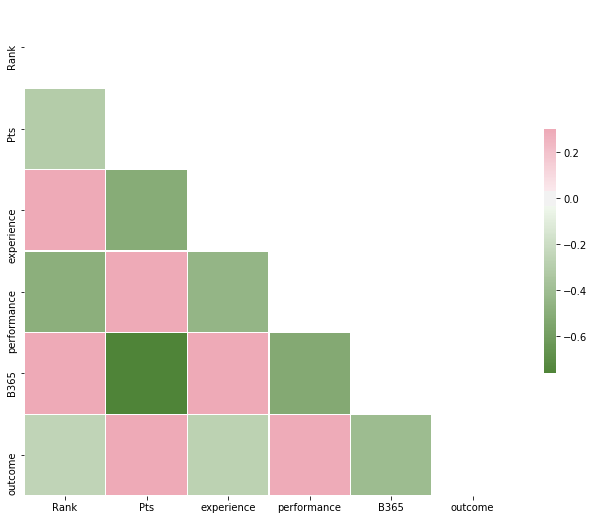

In [73]:
corr = df_atp.drop(columns=["Date"]).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(120, 5, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As we said, the player1 and player2 features are not corrolated with our outcome, so we can drop them safely, also the non-correlation between the outcome and Location,Court,Tournament and Surface justify why we drop the Round before, we will now drop all the unessecery features

In [75]:
df_atp.head()

Date  Rank     Pts  experience  performance  B365    EX  outcome
0 2015-10-28  35.0 -1649.0         291    -0.102567  3.32  2.78        0
1 2017-06-01 -42.0   340.0         -32     0.007519 -2.47 -2.18        1
2 2013-01-14 -72.0  2445.0         -84    -0.060741 -0.59 -0.55        1
3 2007-03-25 -84.0  2396.0        -102     0.341418 -5.40 -6.12        1
4 2006-07-29   6.0   -65.0           2     0.040000  0.68   0.5        0

## <a style="color:#920037"> 2.3 Model creation and testing :</a>

we will predict the outcome for each ATP tennis game during the year 2017.

In [76]:
test_df_atp = df_atp[(df_atp.Date>='2017') & (df_atp.Date<'2018')]
train_atp = df_atp[(df_atp.Date>='2018') | (df_atp.Date<'2017')]
test_df_atp.drop(columns=["Date"],axis=1,inplace=True)
train_atp.drop(columns=["Date"],axis=1,inplace=True)
test_df_atp.reset_index(inplace=True)
test_df_atp.drop(columns="index",inplace=True)
train_atp.reset_index(inplace=True)
train_atp.drop(columns="index",inplace=True)
p = len(test_df_atp.columns)-1
test_array =np.array(test_df_atp)
train_array = np.array(train_atp)
X_train,y_train,X_test,y_test = train_array[:,:p],train_array[:,p].astype(int),test_array[:,:p],test_array[:,p].astype(int)

In [77]:
clf = XGBClassifier()
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [78]:
y_pred = clf.predict(X_test)

In [79]:
print("the accuracy is : ",(accuracy_score(y_test,y_pred)))

the accuracy is :  0.6802464228934817


# <a style="color:#920037"> 3. SUBMISSION ON RAMP </a>

## <a style="color:#920037"> 3.1 Submission files  </a>

In [80]:
class FeatureExtractor(object):
    def __init__(self):
        pass
    
    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        
        X_array = preprocessor.fit_transform(X_encoded)
        return X_array

In [81]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator


class Classificator(BaseEstimator):
    def __init__(self):
        self.classif = XGBClassifier()

    def fit(self, X, y):
        self.classif.fit(X, y)

    def predict(self, X):
        return self.classif.predict(X)

## <a style="color:#920037"> 3.2 Local testing before submitted to RAMP  </a>

You have to test your submissions files before doing your submissions. In that goal, use ramp_test_submission command. Notice that this unit test run in the folder [`submissions/starting_kit`](/tree/submissions/starting_kit).
Before running the test, make sure you have done the following tasks:

- install ramp-workflow
- write the python file classifier.py and feature_extractor.py and put it in the following folder [`submissions/starting_kit`].
- download the data by excuting `python download_data.py`

You have two possibilities to test your submissions, a complete test (train and test the model with cross validtion like the server will do or a quick test (just to make sure the submissions code are working). If the test run, print train and test erros on each fold of the cross validation you can then submit to ramp.

Execute the following cell to do a quick test:

In [ ]:
%run ./download_data.py

In [ ]:
!ramp_test_submission --quick-test